In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib

import os

*/*.JPG, */*.jpg and */*.* all return different values, meaning the dataset has different file types

In [2]:
data_dir = pathlib.Path('plantvillage')

folders = os.listdir(data_dir)

image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)


14529


In [3]:
bacterial_spot = list(data_dir.glob('Tomato___Bacterial_spot/*'))
early_blight = list(data_dir.glob('Tomato___Early_blight/*'))
healthy = list(data_dir.glob('Tomato___healthy/*'))
late_blight = list(data_dir.glob('Tomato___Late_blight/*'))
leaf_mold = list(data_dir.glob('Tomato___Leaf_Mold/*'))
septoria_leaf_spot = list(data_dir.glob('Tomato___Septoria_leaf_spot/*'))
spider_mites = list(data_dir.glob('Tomato___Spider_mites Two-spotted_spider_mite/*'))
target_spot = list(data_dir.glob('Tomato___Target_Spot/*'))
mosaic = list(data_dir.glob('Tomato___Tomato_mosaic_virus/*'))
yellow_leaf_curl = list(data_dir.glob('Tomato___Tomato_Yellow_Leaf_Curl_Virus/*'))

for img in yellow_leaf_curl:
    arr = np.array(PIL.Image.open(img))
    if not (arr.shape == (256, 256, 3)):
        raise Exception

# for subdir in list(data_dir.glob('*')):
#     print(subdir)
#     print(len(list(subdir.glob('*'))))
#     imgs = list(subdir.glob('*'))
#     PIL.Image.open(str(imgs[0]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14529 files belonging to 10 classes.
Using 11624 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-05 21:25:20.854727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-05 21:25:20.855210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 14529 files belonging to 10 classes.
Using 2905 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


2023-02-05 21:25:21.521645: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


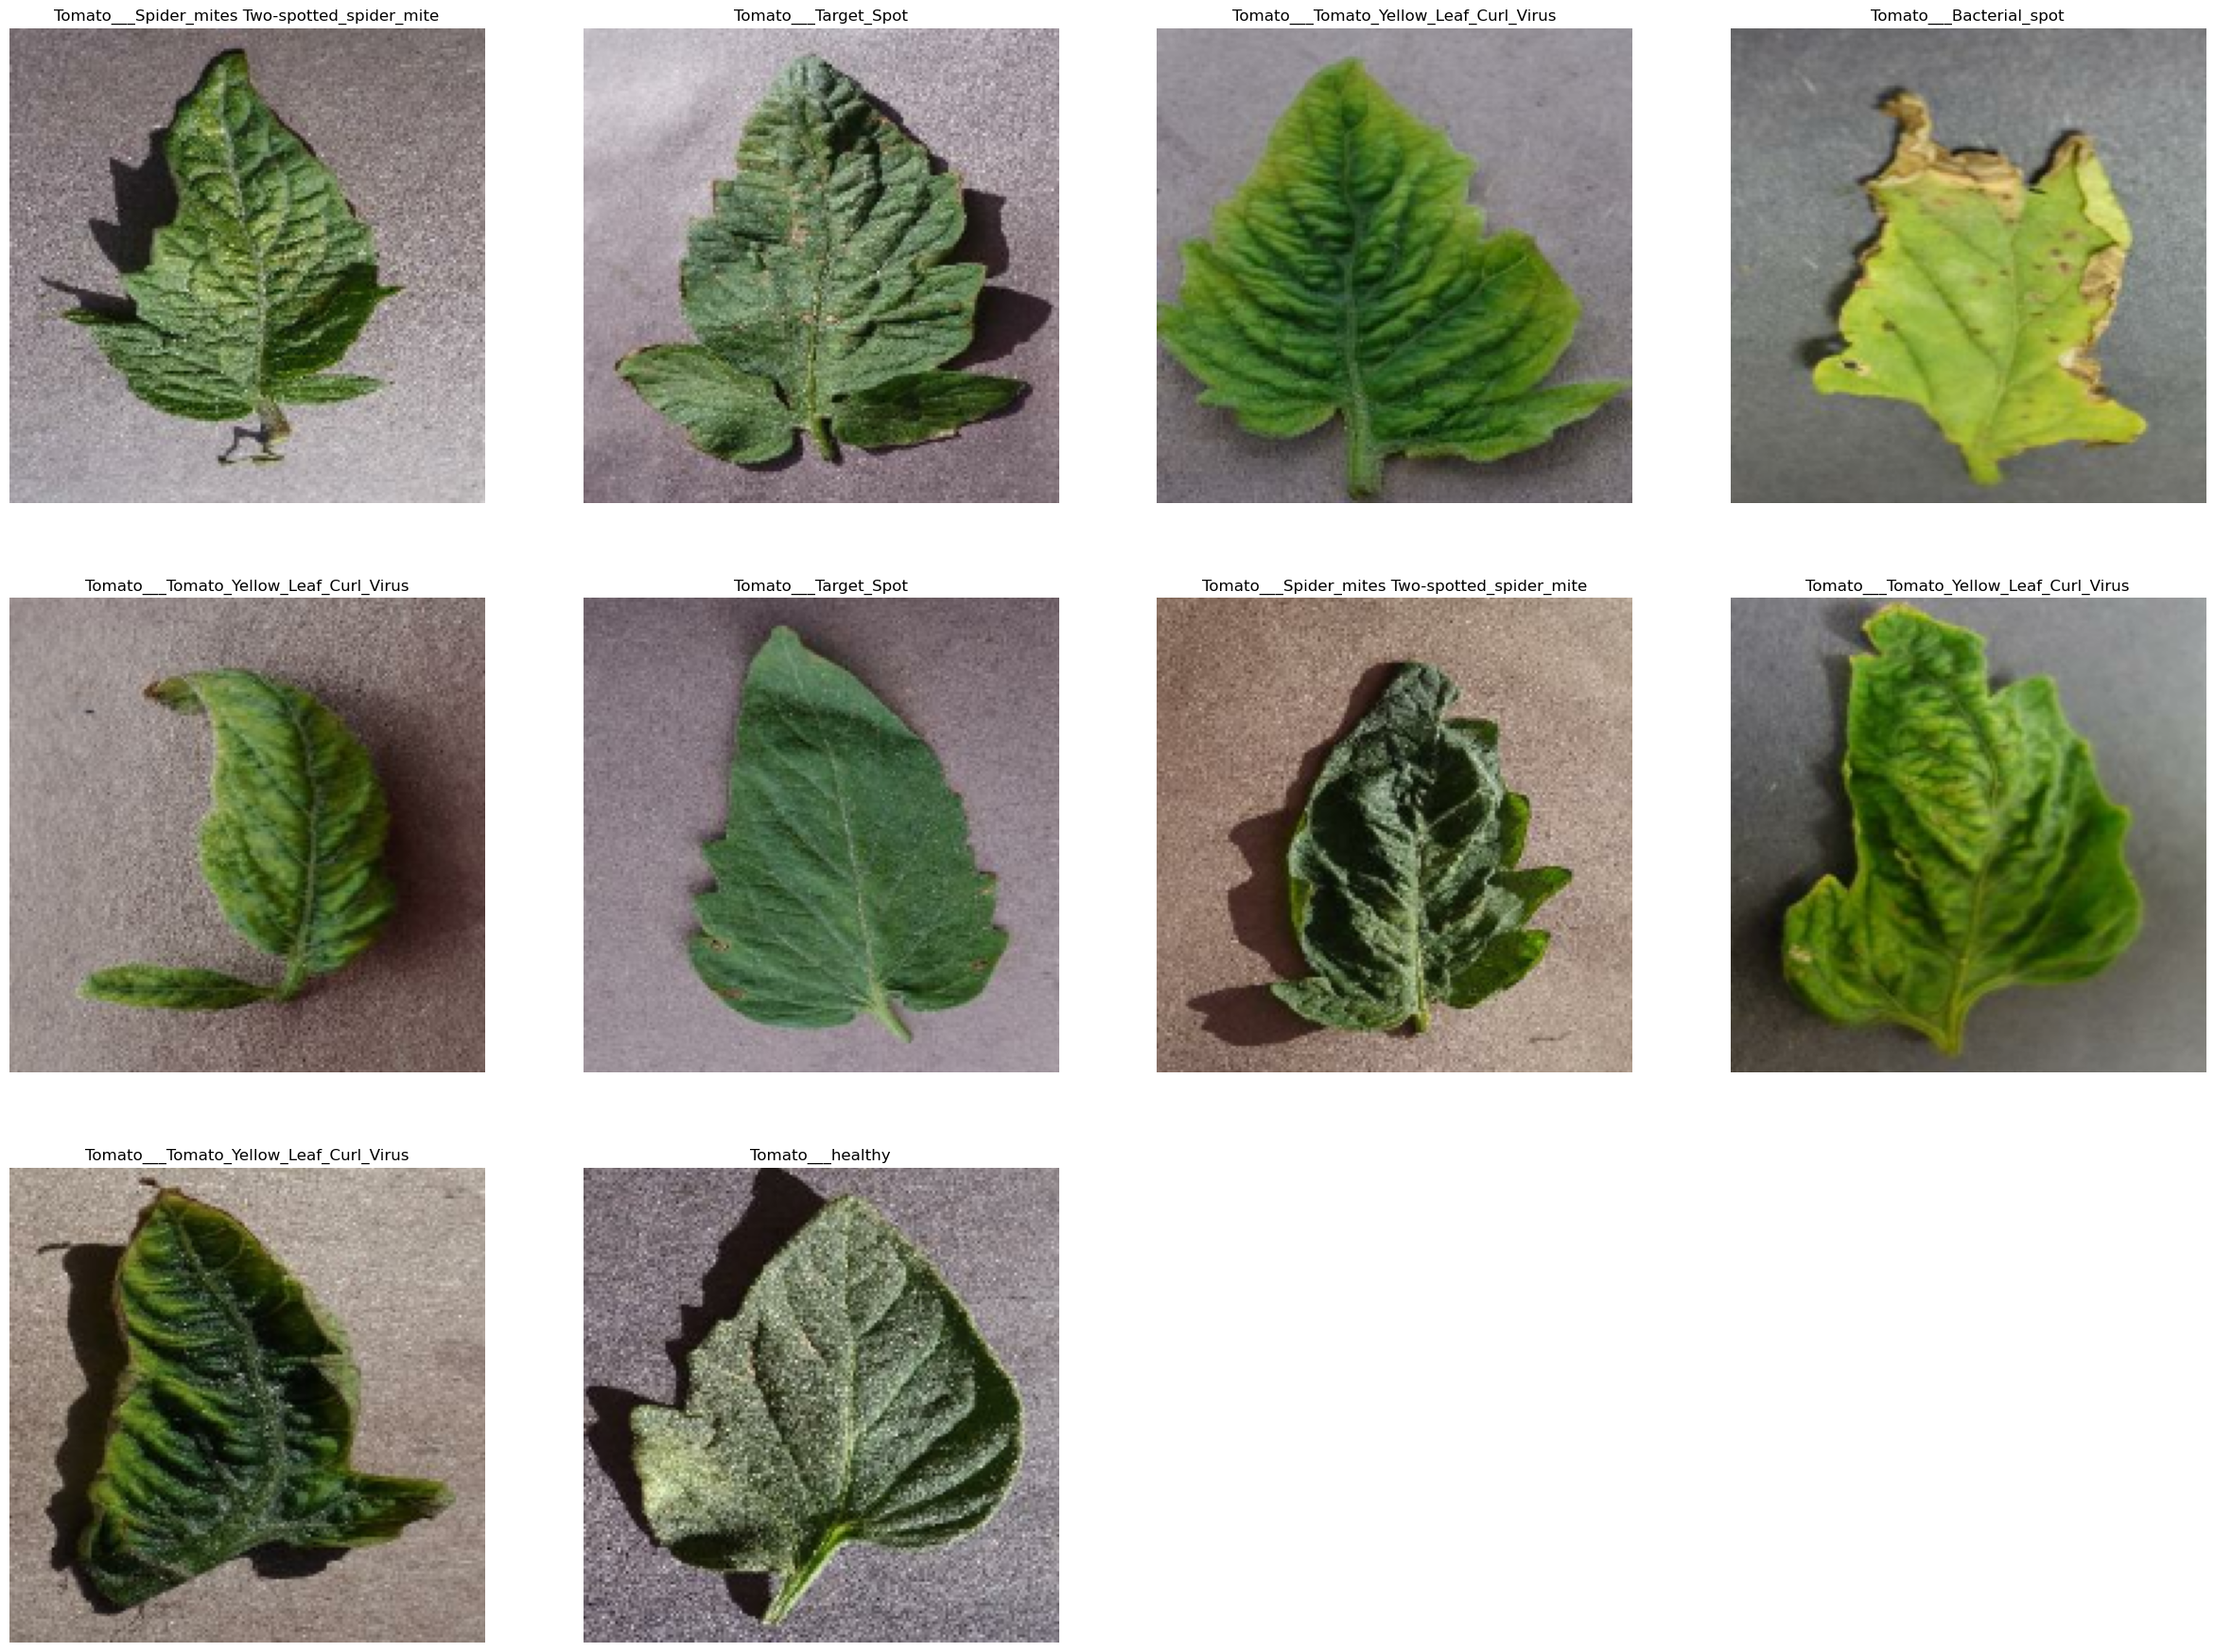

In [6]:
plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(scale=1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9781756


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [11]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-02-05 21:25:30.457572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - ETA: 0s - loss: 1.0122 - accuracy: 0.6562

2023-02-05 21:27:57.421134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 151s 408ms/step - loss: 1.0122 - accuracy: 0.6562 - val_loss: 0.6900 - val_accuracy: 0.7752
Epoch 2/10
364/364 [==============================] - 150s 413ms/step - loss: 0.5099 - accuracy: 0.8258 - val_loss: 0.5350 - val_accuracy: 0.8220
Epoch 3/10
364/364 [==============================] - 150s 411ms/step - loss: 0.3821 - accuracy: 0.8673 - val_loss: 0.5240 - val_accuracy: 0.8296
Epoch 4/10
364/364 [==============================] - 152s 416ms/step - loss: 0.3055 - accuracy: 0.8959 - val_loss: 0.4457 - val_accuracy: 0.8530
Epoch 5/10
364/364 [==============================] - 158s 435ms/step - loss: 0.2437 - accuracy: 0.9149 - val_loss: 0.5422 - val_accuracy: 0.8375
Epoch 6/10
364/364 [==============================] - 151s 414ms/step - loss: 0.2115 - accuracy: 0.9258 - val_loss: 0.4842 - val_accuracy: 0.8499
Epoch 7/10
364/364 [==============================] - 151s 415ms/step - loss: 0.1812 - accuracy: 0.9339 - val_loss: 0.4785 - val_accura

In [ ]:
import datetime

# print(str(datetime.datetime.now()))
model.save('saved_model/model'+str(datetime.datetime.now()))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(val_ds)

CLASSIFY NEW DATA

In [ ]:
leaf_path = pathlib.Path('yellowcurl2.png')

img = tf.keras.utils.load_img(
    leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)